## Import libraries

In [54]:
# pyspark libraries
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, FloatType
from pyspark.sql.functions import col, udf, when
# Python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## User Defined Functions

In [3]:
def convert_string_to_float(x):
    x_replace_minus = x.replace(u'\u2212', '-')
    if x_replace_minus == '-':
        return np.nan
    else:
        return float(x_replace_minus)

udf_convert_string_to_float = udf(lambda x: convert_string_to_float(x), FloatType())

In [20]:
def get_date_string(date, month, year):
    return year + "/" + month + "/" + date

udf_get_date_string = udf(lambda date, month, year: get_date_string(date, month, year), StringType())

In [80]:
def win_team_1(score_team_1, score_team_2):
    if score_team_1 > score_team_2:
        return 1
    elif score_team_1 < score_team_2:
        return 0
    else:
        return -1
    
udf_win_team_1 = udf(lambda team_1, team_2: win_team_1(team_1, team_2), IntegerType())

## Dataset: Teams

In [4]:
schema = StructType([
    StructField("id", StringType(), True),
    StructField("country", StringType(), True)])
teams = spark.read.csv("../data/AFC/en.teams.tsv", sep="\t", header=False, schema=schema)

In [6]:
print("Dataset teams format: {0}".format(teams.dtypes))
print("Number of country: {0}".format(teams.count()))
# Check if some countries are identified with the same id
# print("Country with similar id string:")
# teams.groupBy("id").count().filter(col("count") != 1).show()
print("Preview of the dataset:")
teams.show(3)

Dataset teams format: [('id', 'string'), ('country', 'string')]
Number of country: 313
Preview of the dataset:
+---+-----------+
| id|    country|
+---+-----------+
| AN|       Aden|
| AF|Afghanistan|
| AL|    Albania|
+---+-----------+
only showing top 3 rows



## Dataset: 2014_World_Cup_AFC_qualifying_start

In [8]:
schema = StructType([
    StructField("rankGroup_local", StringType(), True),
    StructField("rankGroup_global", StringType(), True),
    StructField("teamGroup_team", StringType(), True),
    StructField("ratingGroup_rating", StringType(), True),
    StructField("highestGroup_rank_max", StringType(), True),
    StructField("highestGroup_rating_max", StringType(), True),
    StructField("averageGroup_rank_avg", StringType(), True),
    StructField("averageGroup_rating_avg", StringType(), True),
    StructField("lowestGroup_rank_min", StringType(), True),
    StructField("lowestGroup_rating_min", StringType(), True),
    StructField("change3mGroup_rank_three_month_change", StringType(), True),
    StructField("change3mGroup_rating_three_month_change", StringType(), True),
    StructField("change6mGroup_rank_six_month_change", StringType(), True),
    StructField("change6mGroup_rating_six_month_change", StringType(), True),
    StructField("change1yGroup_rank_one_year_change", StringType(), True),
    StructField("change1yGroup_rating_one_year_change", StringType(), True),
    StructField("change2yGroup_rank_two_year_change", StringType(), True),
    StructField("change2yGroup_rating_two_year_change", StringType(), True),
    StructField("change5yGroup_rank_five_year_change", StringType(), True),
    StructField("change5yGroup_rating_five_year_change", StringType(), True),
    StructField("change10yGroup_rank_ten_year_change", StringType(), True),
    StructField("change10yGroup_rating_ten_year_change", StringType(), True),
    StructField("matchesGroup_total", StringType(), True),
    StructField("matchesGroup_home", StringType(), True),
    StructField("matchesGroup_away", StringType(), True),
    StructField("matchesGroup_neutral", StringType(), True),
    StructField("matchesGroup_wins", StringType(), True),
    StructField("matchesGroup_losses", StringType(), True),
    StructField("matchesGroup_draws", StringType(), True),
    StructField("goalsGroup_for", StringType(), True),
    StructField("goalsGroup_against", StringType(), True)
])

names_to_convert = schema.names
names_to_convert.remove("teamGroup_team")


AFC_qualifying_start = spark.read.csv("../data/AFC/2014_World_Cup_AFC_qualifying_start.tsv", sep="\t", 
                                      schema=schema, header=False)\
                                 .select([udf_convert_string_to_float(col(name)).alias(name) for name in names_to_convert] + ["teamGroup_team"])

In [9]:
print("Number of teams with available statistic: {0}".format(AFC_qualifying_start.count()))

Number of teams with available statistic: 43


### Where the matches are played

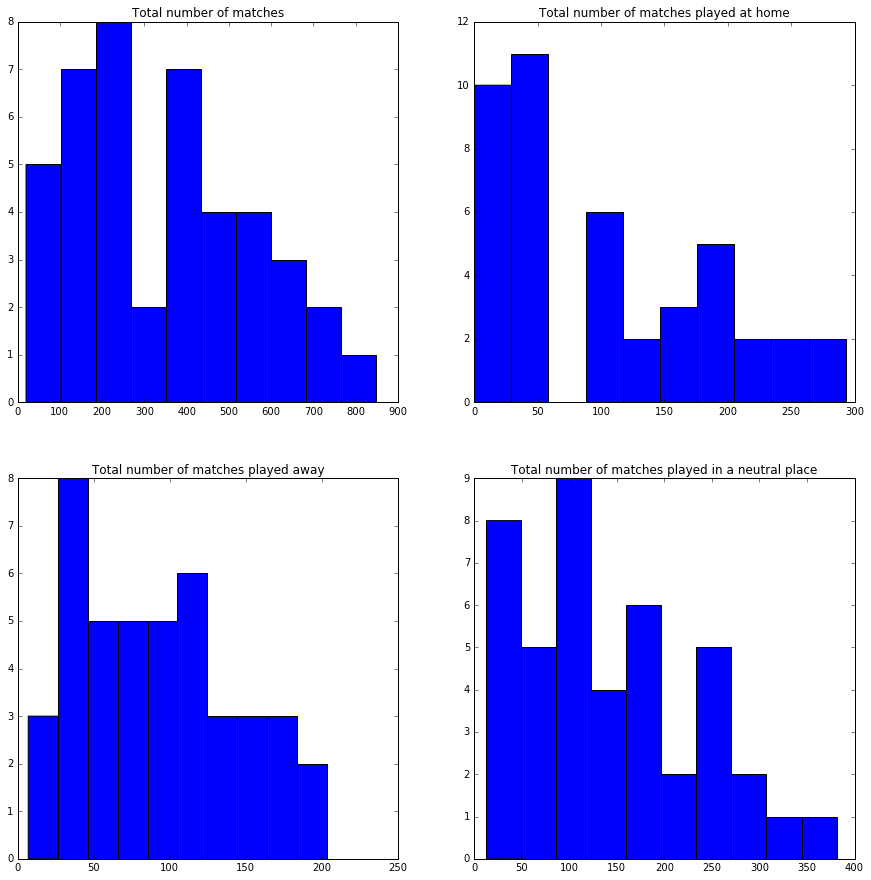

In [65]:
matches_group = AFC_qualifying_start\
.select("matchesGroup_total", "matchesGroup_home", "matchesGroup_away", "matchesGroup_neutral")\
.rdd\
.map(lambda x: (x["matchesGroup_total"], x["matchesGroup_home"], x["matchesGroup_away"], x["matchesGroup_neutral"]))\
.collect()

total = map(lambda x: x[0], matches_group)
home = map(lambda x: x[1], matches_group)
away = map(lambda x: x[2], matches_group)
neutral = map(lambda x: x[3], matches_group)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15));
ax[0][0].hist(total);
ax[0][0].set_title("Total number of matches");

ax[0][1].hist(home);
ax[0][1].set_title("Total number of matches played at home");

ax[1][0].hist(away);
ax[1][0].set_title("Total number of matches played away");

ax[1][1].hist(neutral);
ax[1][1].set_title("Total number of matches played in a neutral place");

### Wins/Losses/Draws matches

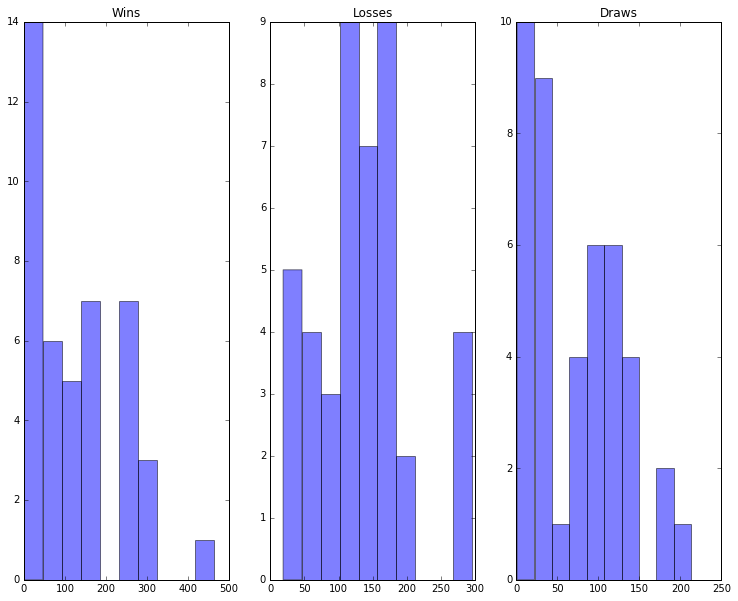

In [77]:
wins_losses_draws = AFC_qualifying_start.select("matchesGroup_wins", "matchesGroup_losses", "matchesGroup_draws")\
    .rdd\
    .map(lambda x: (x["matchesGroup_wins"], x["matchesGroup_losses"], x["matchesGroup_draws"]))\
    .collect()
    
wins = map(lambda x: x[0], wins_losses_draws)
losses = map(lambda x: x[1], wins_losses_draws)
draws = map(lambda x: x[2], wins_losses_draws)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12.5,10));
ax[0].hist(wins, alpha=0.5, bins=10, label="wins");
ax[1].hist(losses, alpha=0.5, bins=10, label="losses");
ax[2].hist(draws, alpha=0.5, bins=10, label="draws");
ax[0].set_title("Wins");
ax[1].set_title("Losses");
ax[2].set_title("Draws");

## Dataset: 2014_World_Cup_AFC_qualifying_results

In [34]:
schema = StructType([
    StructField("year", StringType(), True),
    StructField("month", StringType(), True),
    StructField("date", StringType(), True),
    StructField("team_1", StringType(), True),
    StructField("team_2", StringType(), True),
    StructField("score_team_1", IntegerType(), True),
    StructField("score_team_2", IntegerType(), True),
    StructField("tournament", StringType(), True),
    StructField("country_played", StringType(), True),
    StructField("rating_moved", StringType(), True),
    StructField("rating_team_1", StringType(), True),
    StructField("rating_team_2", StringType(), True),
    StructField("rank_moved_team_1", StringType(), True),
    StructField("rank_moved_team_2", StringType(), True),
    StructField("rank_team_1", StringType(), True),
    StructField("rank_team_2", StringType(), True)
])

AFC_qualifying_results = spark.read.csv("../data/AFC/2014_World_Cup_AFC_qualifying_results.tsv", sep="\t", 
                                        schema=schema, header=False)\
                              .withColumn("new_date", udf_get_date_string(col("date"), col("month"), col("year")))\
                              .drop("date").drop("month").drop("year").withColumnRenamed("new_date", "date")

names_to_convert = AFC_qualifying_results.schema.names
names_to_remove = ["date",  "team_1", "team_2", "score_team_1", "score_team_2", "tournament", "country_played"]
for name in names_to_remove: names_to_convert.remove(name)


AFC_qualifying_results = AFC_qualifying_results\
                         .select([udf_convert_string_to_float(col(name)).alias(name) for name in names_to_convert] + names_to_remove)    

In [35]:
AFC_qualifying_results.printSchema()

root
 |-- rating_moved: float (nullable = true)
 |-- rating_team_1: float (nullable = true)
 |-- rating_team_2: float (nullable = true)
 |-- rank_moved_team_1: float (nullable = true)
 |-- rank_moved_team_2: float (nullable = true)
 |-- rank_team_1: float (nullable = true)
 |-- rank_team_2: float (nullable = true)
 |-- date: string (nullable = true)
 |-- team_1: string (nullable = true)
 |-- team_2: string (nullable = true)
 |-- score_team_1: integer (nullable = true)
 |-- score_team_2: integer (nullable = true)
 |-- tournament: string (nullable = true)
 |-- country_played: string (nullable = true)



In [84]:
AFC_qualifying_results = AFC_qualifying_results.select("team_1", "team_2", "score_team_1", "score_team_2")\
.withColumn("win_team_1", udf_win_team_1(col("score_team_1"), col("score_team_2")))

In [85]:
AFC_qualifying_results.groupBy("win_team_1").count().show()

+----------+-----+
|win_team_1|count|
+----------+-----+
|        -1|  166|
|         1|  445|
|         0|  111|
+----------+-----+

